# Code for model estimation

In [28]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

In [3]:
from sklearn.metrics import precision_recall_fscore_support
# precision_recall_fscore_support(df_val['true_value'], df_val['pred_value'], average='weighted')

In [4]:
import seaborn as sn

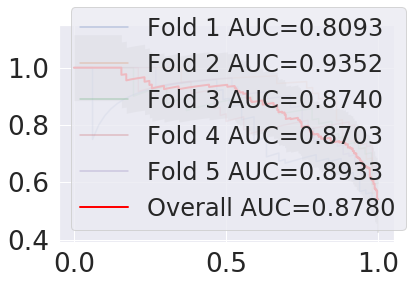

In [41]:
# https://stackoverflow.com/questions/55541254/precision-recall-curve-with-n-fold-cross-validation-showing-standard-deviation

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from numpy import interp
from sklearn.metrics import auc

X, y = make_blobs(n_samples=500, n_features=2, centers=2, cluster_std=10.0,
    random_state=10)

k_fold = KFold(n_splits=5, shuffle=True, random_state=10)
predictor = SVC(kernel='linear', C=1.0, probability=True, random_state=10)

y_real = []
y_proba = []

precision_array = []
threshold_array=[]
recall_array = np.linspace(0, 1, 100)

for i, (train_index, test_index) in enumerate(k_fold.split(X)):
    Xtrain, Xtest = X[train_index], X[test_index]
    ytrain, ytest = y[train_index], y[test_index]
    predictor.fit(Xtrain, ytrain)
    pred_proba = predictor.predict_proba(Xtest)
    precision_fold, recall_fold, thresh = precision_recall_curve(ytest, pred_proba[:,1])
    precision_fold, recall_fold, thresh = precision_fold[::-1], recall_fold[::-1], thresh[::-1]  # reverse order of results
    thresh = np.insert(thresh, 0, 1.0)
    precision_array = interp(recall_array, recall_fold, precision_fold)
    threshold_array = interp(recall_array, recall_fold, thresh)
    pr_auc = auc(recall_array, precision_array)

    lab_fold = 'Fold %d AUC=%.4f' % (i+1, pr_auc)
    plt.plot(recall_fold, precision_fold, alpha=0.3, label=lab_fold)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'Overall AUC=%.4f' % (auc(recall, precision))

plt.plot(recall, precision, lw=2,color='red', label=lab)

plt.legend(loc='lower left', fontsize='small')

mean_precision = np.mean(precision_array)
std_precision = np.std(precision_array)
plt.fill_between(recall, precision + std_precision, precision - std_precision, alpha=0.3, linewidth=0, color='grey')
plt.show()

# Metrics calculation

In [42]:
from sklearn.metrics import roc_auc_score

class MultiClassMetrics():
    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        
    def calculate_scores(self, class_mapping_dict=None, classes_n=None):
    
        y_true_ = self.y_true
        y_pred_ = self.y_pred

        if classes_map_dict is not None and classes_n is not None:
            raise Exception('classes_map_dict cannot be used with classes_n (which is used to deal with missing entries actual/predicted classes)!')

        # now in case some of the classes was not present in y_true or y_pred - we will add them
        if classes_n is not None:
            y_true_ = np.hstack((y_true_, list(range(classes_n))))
            y_pred_ = np.hstack((y_pred_, list(range(classes_n))))

        if classes_map_dict is not None:
            y_true_ = y_true_.map(classes_map_dict)
            y_pred_ = y_pred_.map(classes_map_dict)
    
        self.cnf_matrix = confusion_matrix(y_true_, y_pred_)
        if classes_n is not None:
            for i in range(classes_n):
                self.cnf_matrix[i,i] = self.cnf_matrix[i,i] - 1  #self.cnf_matrix[np.diag_indices_from(self.cnf_matrix)] = self.cnf_matrix[np.diag_indices_from(self.cnf_matrix)] - 1

    
        self.cnf_matrix = confusion_matrix(y_true_, y_pred_)
        self.FP = self.cnf_matrix.sum(axis=0) - np.diag(self.cnf_matrix) 
        self.FN = self.cnf_matrix.sum(axis=1) - np.diag(self.cnf_matrix)
        self.TP = np.diag(self.cnf_matrix)
        self.TN = self.cnf_matrix.sum() - (self.FP + self.FN + self.TP)
        self.FP = self.FP.astype(float)
        self.FN = self.FN.astype(float)
        self.TP = self.TP.astype(float)
        self.TN = self.TN.astype(float)
        # Sensitivity, hit rate, recall, or true positive rate
        self.TPR = self.TP/(self.TP+self.FN)
        # Specificity or true negative rate
        self.TNR = self.TN/(self.TN+self.FP) 
        # Precision or positive predictive value
        self.PPV = self.TP/(self.TP+self.FP)
        # Negative predictive value
        self.NPV = self.TN/(self.TN+self.FN)
        # Fall out or false positive rate
        self.FPR = self.FP/(self.FP+self.TN)
        # False negative rate
        self.FNR = self.FN/(self.TP+self.FN)
        # False discovery rate
        self.FDR = self.FP/(self.TP+self.FP)
        # Overall accuracy for each class
        self.ACC = (self.TP+self.TN)/(self.TP+self.FP+self.FN+self.TN)

        self.F1_micro = f1_score(y_true_, y_pred_, average='micro')
        self.F1_macro = f1_score(y_true_, y_pred_, average='macro')
        self.F1_weighted = f1_score(y_true_, y_pred_, average='weighted')
        
#         self.AUC = auc(y_true_, y_pred_)

class MultiClassFoldsMetrics():
    def __init__(self, multi_class_metrics_list):
        self.multi_class_metrics_list = multi_class_metrics_list
        
    def calc_scores(self, class_mapping_dict=None, classes_n=None):
#         classes_n = self.multi_class_metrics_list[0].y_true.unique().shape[0]
        folds_n = len(self.multi_class_metrics_list)
        
        self.classes_n = classes_n
        self.folds_n = folds_n
        
        self.TPR_arr = np.zeros((folds_n, classes_n))
        self.TNR_arr = np.zeros((folds_n, classes_n))
        self.PPV_arr = np.zeros((folds_n, classes_n))
        self.NPV_arr = np.zeros((folds_n, classes_n))
        self.FPR_arr = np.zeros((folds_n, classes_n))
        self.FNR_arr = np.zeros((folds_n, classes_n))
        self.FDR_arr = np.zeros((folds_n, classes_n))
        self.ACC_arr = np.zeros((folds_n, classes_n))
        self.F1_micro_arr = np.zeros((folds_n))
        self.F1_macro_arr = np.zeros((folds_n))
        self.F1_weighted_arr = np.zeros((folds_n))
        self.cnf_matrix_arr = np.zeros((classes_n, classes_n))
#         self.AUC_arr = np.zeros((folds_n, classes_n))
        
        fold_n = 0
        for m in self.multi_class_metrics_list:
            m.calculate_scores(class_mapping_dict, classes_n=classes_n)

            self.TPR_arr[fold_n,:]=m.TPR
            self.TNR_arr[fold_n,:]=m.TNR
            self.PPV_arr[fold_n,:]=m.PPV
            self.NPV_arr[fold_n,:]=m.NPV
            self.FPR_arr[fold_n,:]=m.FPR
            self.FNR_arr[fold_n,:]=m.FNR
            self.FDR_arr[fold_n,:]=m.FDR
            self.ACC_arr[fold_n,:]=m.ACC
            self.F1_micro_arr[fold_n]=m.F1_micro
            self.F1_macro_arr[fold_n]=m.F1_macro
            self.F1_weighted_arr[fold_n]=m.F1_weighted
            self.cnf_matrix_arr = np.add(self.cnf_matrix_arr, m.cnf_matrix)
            
#             self.AUC_arr = m.AUC
            
            fold_n = fold_n + 1
            
    def print_scores(self):
        print('TPR={}, TNR={}, PPV={}, NPV={}, FPR={}, FNR={}, FDR={}, ACC={}, F1_micro={}, F1_macro={}, F1_weighted={}'.format(  #, AUC={}
                self.TPR_arr.mean(axis=0), 
                self.TNR_arr.mean(axis=0), 
                self.PPV_arr.mean(axis=0), 
                self.NPV_arr.mean(axis=0), 
                self.FPR_arr.mean(axis=0), 
                self.FNR_arr.mean(axis=0), 
                self.FDR_arr.mean(axis=0), 
                self.ACC_arr.mean(axis=0), 
                self.F1_micro_arr.mean(), 
                self.F1_macro_arr.mean(), 
                self.F1_weighted_arr.mean()  #,
#                 self.AUC_arr.mean(axis=0) 
                )
             )
        print('{}'.format(self.cnf_matrix_arr))
        
    def print_mean_classification_report(self, classes_map_dict=None, target_names=None):
        y_true_, y_pred_ = self.collect_ys(classes_map_dict)
        print(classification_report(y_true_, y_pred_, target_names=target_names))
        
    def collect_ys(self, classes_map_dict=None):
        y_true_ = pd.Series()
        y_pred_ = pd.Series()
        for m in self.multi_class_metrics_list:
            __y_tr = m.y_true.copy()
            __y_pr = m.y_pred.copy()
            
            if classes_map_dict is not None:
                __y_tr = __y_tr.map(classes_map_dict)
                __y_pr = __y_pr.map(classes_map_dict)
                
            y_true_ = y_true_.append(__y_tr, ignore_index=True, verify_integrity=False)
            y_pred_ = y_pred_.append(__y_pr, ignore_index=True, verify_integrity=False)
            
        return y_true_, y_pred_
        


In [43]:
def build_multi_class_metrics_list(val_file_template, layer, set_id, folds_n, classes_n):
    
    multi_class_metrics_list = []
    for fold_n in range(folds_n):
        file_path=val_file_template.format(layer, set_id, fold_n)
        df = pd.read_csv(file_path)
        
        true_value = df['true_value']
        pred_value = df['pred_value']
        
        multi_class_metric = MultiClassMetrics(true_value, pred_value)
        multi_class_metrics_list.append(multi_class_metric)
        
    return MultiClassFoldsMetrics(multi_class_metrics_list)

In [8]:
# val_file_template="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation4_logits_predictions.csv"
# train_file_template="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train4_logits_predictions.csv"

val_file_template="/mnt/models/darts_retrained/4ch_128x128_12inchannel_no_metainfo_registered_5Fold_newC43_augC43_v1_21Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_15Dec_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation7ch_logits_predictions.csv"
train_file_template=     "/mnt/models/darts_retrained/4ch_128x128_12inchannel_no_metainfo_registered_5Fold_newC43_augC43_v1_21Dec2020/XV2_SGD_orig_02DropChannel_{}lrs_15Dec_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train7ch_logits_predictions.csv"



# ClassSet1

In [13]:
layers = [1,2,3,4,5]
sets = [1]

folds_n = 5
classes_n = 2

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = validation_file_path.format()
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign'])
      
        
        print('--------------------------------')
        
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign'])
        
        print('--------------------------------')
        print('================================')
        print('--------------------------------')

Layers-1, Set-1
Validation:
TPR=[0.62344988 0.95520388], TNR=[0.95520388 0.62344988], PPV=[0.71391746 0.94030712], NPV=[0.94030712 0.71391746], FPR=[0.04479612 0.37655012], FNR=[0.37655012 0.04479612], FDR=[0.28608254 0.05969288], ACC=[0.90854609 0.90854609], F1_micro=0.9085460876106112, F1_macro=0.7992925888803171, F1_weighted=0.9061929732501082
[[ 41.  25.]
 [ 18. 387.]]
                       precision    recall  f1-score   support

Melanoma_like_lesions       0.69      0.62      0.66        66
     Pigmented_benign       0.94      0.96      0.95       405

             accuracy                           0.91       471
            macro avg       0.82      0.79      0.80       471
         weighted avg       0.91      0.91      0.91       471

--------------------------------
Training:
TPR=[0.83320437 0.99319055], TNR=[0.99319055 0.83320437], PPV=[0.95254041 0.97340558], NPV=[0.97340558 0.95254041], FPR=[0.00680945 0.16679563], FNR=[0.16679563 0.00680945], FDR=[0.04745959 0.02659442

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.96915251 0.99876922], TNR=[0.99876922 0.96915251], PPV=[0.99252271 0.99509555], NPV=[0.99509555 0.99252271], FPR=[0.00123078 0.03084749], FNR=[0.03084749 0.00123078], FDR=[0.00747729 0.00490445], ACC=[0.99466935 0.99466935], F1_micro=0.9946693520730813, F1_macro=0.9885872630897176, F1_weighted=0.994605230250874
[[ 256.    8.]
 [   2. 1618.]]
                       precision    recall  f1-score   support

Melanoma_like_lesions       0.99      0.97      0.98       264
     Pigmented_benign       1.00      1.00      1.00      1620

             accuracy                           0.99      1884
            macro avg       0.99      0.98      0.99      1884
         weighted avg       0.99      0.99      0.99      1884

--------------------------------
--------------------------------
Layers-3, Set-1
Validation:
TPR=[0.56247086 0.9699004 ], TNR=[0.9699004  0.56247086], PPV=[0.79047619 0.93325291], NPV=[0.93325291 0.79047619], FPR=[0.0300996  0.43752914], FNR=[0.43752914 0.0300996 ], 

# 2 - layers is the best (looking at F1) 

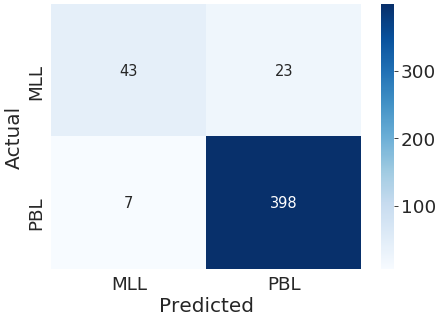

In [32]:
data = np.array([[ 43.,  23.],
                 [  7., 398.]])
if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL'], index = ['MLL', 'PBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='g')# font size

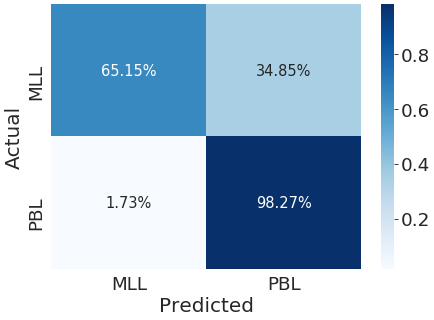

In [31]:
data = np.array([[ 43.,  23.],
                 [  7., 398.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL'], index = ['MLL', 'PBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='.2%')# font size

# ClassSet3

In [48]:
layers = [1,2,3,4,5]
sets = [3]

folds_n = 5
classes_n = 4

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1}
#         classes_map_dict={0:1, 1:0, 2:0, 3:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0}
#         classes_map_dict={0:1, 1:0, 2:0, 3:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL'])
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL'])        
        print('--------------------------------')
        print('================================')
        print('--------------------------------')

Layers-1, Set-3
Validation:
TPR=[0.54857809 0.84653727 0.6292947  0.60207962], TNR=[0.97783377 0.79302215 0.87146861 0.92926139], PPV=[0.69861111 0.77792959 0.65185856 0.67880684], NPV=[0.96440366 0.86000566 0.86048023 0.90776032], FPR=[0.02216623 0.20697785 0.12853139 0.07073861], FNR=[0.45142191 0.15346273 0.3707053  0.39792038], FDR=[0.30138889 0.22207041 0.34814144 0.32119316], ACC=[0.94587822 0.81676072 0.80339415 0.86626854], F1_micro=0.7161508140255517, F1_macro=0.6691409779328008, F1_weighted=0.7114113270062303
[[ 36.  19.   4.   7.]
 [  5. 343.  38.  19.]
 [  5.  63. 155.  25.]
 [  8.  20.  40. 103.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.67      0.55      0.60        66
       Pigmented_benign       0.77      0.85      0.81       405
        Keratin_lesions       0.65      0.62      0.64       248
Nonmelanoma_skin_cancer       0.67      0.60      0.63       171

               accuracy                           0.72 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.77279472 0.93895143 0.82813396 0.82724473], TNR=[0.989969   0.89086464 0.9525621  0.97188817], PPV=[0.86117182 0.87955212 0.8730581  0.87515039], NPV=[0.98196086 0.94663994 0.93538327 0.95955201], FPR=[0.010031   0.10913536 0.0474379  0.02811183], FNR=[0.22720528 0.06104857 0.17186604 0.17275527], FDR=[0.13882818 0.12044788 0.1269419  0.12484961], ACC=[0.9738665  0.91285267 0.91796065 0.94408878], F1_micro=0.8743843017414321, F1_macro=0.8550112043385362, F1_weighted=0.8731548809016498
[[ 204.   41.    9.   10.]
 [  13. 1521.   62.   24.]
 [   5.  118.  822.   47.]
 [  15.   52.   51.  566.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.86      0.77      0.81       264
       Pigmented_benign       0.88      0.94      0.91      1620
        Keratin_lesions       0.87      0.83      0.85       992
Nonmelanoma_skin_cancer       0.87      0.83      0.85       684

               accuracy                           0.87      3560
  

TPR=[0.93174215 0.97717706 0.94356266 0.93566745], TNR=[0.99179456 0.97625052 0.98249932 0.98714873], PPV=[0.90234541 0.97211503 0.95495261 0.94571148], NPV=[0.99452439 0.98104245 0.97844211 0.98475591], FPR=[0.00820544 0.02374948 0.01750068 0.01285127], FNR=[0.06825785 0.02282294 0.05643734 0.06433255], FDR=[0.09765459 0.02788497 0.04504739 0.05428852], ACC=[0.98734441 0.97669366 0.97164792 0.97724092], F1_micro=0.956463454298001, F1_macro=0.9449938288141972, F1_weighted=0.9564600102177533
[[ 246.   11.    4.    3.]
 [   9. 1583.   20.    8.]
 [   3.   27.  936.   26.]
 [  15.    8.   21.  640.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.90      0.93      0.92       264
       Pigmented_benign       0.97      0.98      0.97      1620
        Keratin_lesions       0.95      0.94      0.95       992
Nonmelanoma_skin_cancer       0.95      0.94      0.94       684

               accuracy                           0.96      3560
   

              precision    recall  f1-score   support

  MLL+NonMSC       0.76      0.72      0.74       237
       PB+KL       0.90      0.92      0.91       653

    accuracy                           0.87       890
   macro avg       0.83      0.82      0.82       890
weighted avg       0.86      0.87      0.86       890

--------------------------------
--------------------------------
--------------------------------
Training:
TPR=[0.96943202 0.98458464 0.96265789 0.95469939], TNR=[0.99303125 0.98912551 0.98908992 0.98993096], PPV=[0.91877006 0.9870514  0.97165181 0.95795626], NPV=[0.99755572 0.98721675 0.9856809  0.98925072], FPR=[0.00696875 0.01087449 0.01091008 0.01006904], FNR=[0.03056798 0.01541536 0.03734211 0.04530061], FDR=[0.08122994 0.0129486  0.02834819 0.04204374], ACC=[0.99129169 0.98707438 0.98172538 0.98315081], F1_micro=0.9716211250706579, F1_macro=0.9629668647245838, F1_weighted=0.9716767404126291
[[2.560e+02 5.000e+00 2.000e+00 1.000e+00]
 [8.000e+00 1.595e+03 1.

### 2 - layers give best for F1

[Text(0, 0.5, 'MLL'),
 Text(0, 1.5, 'PBL'),
 Text(0, 2.5, 'KL'),
 Text(0, 3.5, 'NMSC')]

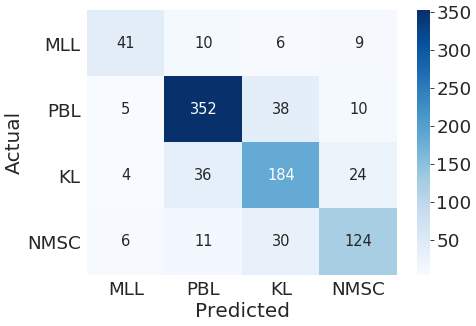

In [21]:
# data = np.array([[ 53.,   8.,   1.,   4.],
#                  [ 11., 352.,  33.,  10.],
#                  [  3.,  32., 182.,  31.],
#                  [  9.,  15.,  32., 115.]])

data = np.array([[ 41.,  10.,   6.,   9.],
                 [  5., 352.,  38.,  10.],
                 [  4.,  36., 184.,  24.],
                 [  6.,  11.,  30., 124.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NMSC'], index = ['MLL', 'PBL', 'KL', 'NMSC'])
# df_cm.index.name = 'Actual'
# df_cm.columns.name = 'Predicted'
# plt.figure(figsize = (10,7), dpi=50)
# sn.set(font_scale=2.4)#for label size
# sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='g')# font size
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
g = sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='g')# font size .2%
g.set_yticklabels(labels=['MLL', 'PBL', 'KL', 'NMSC'], rotation=0)

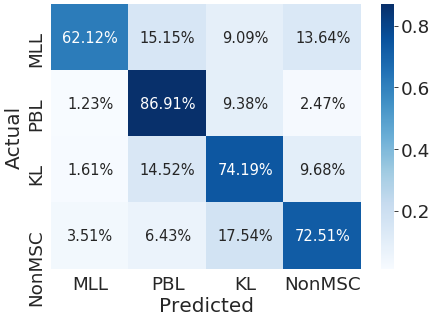

In [50]:
data = np.array([[ 41.,  10.,   6.,   9.],
                 [  5., 352.,  38.,  10.],
                 [  4.,  36., 184.,  24.],
                 [  6.,  11.,  30., 124.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NMSC'], index = ['MLL', 'PBL', 'KL', 'NMSC'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='.2%')# font size

## 4 klasēm: skin cancer (MLL+NonMSC) vs. benign lesions (PBL+KL) 

In [52]:
layers = [1,2,3,4,5]
sets = [3]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
#         multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
    
        print('--------------------------------')    
#         print('NonMSC vs MLL+PB+KL+Other:')
        print('MLL+NonMSC vs PB+KL:')
        classes_map_dict={0:0, 1:1, 2:0, 3:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL'])
        
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
        
        print('--------------------------------')    
#         print('NonMSC vs MLL+PB+KL+Other:')1aw2
        print('MLL+NonMSC vs PB+KL:')
        classes_map_dict={0:0, 1:1, 2:0, 3:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-3
Validation:
--------------------------------
MLL+NonMSC vs PB+KL:
TPR=[0.64175824 0.84127317], TNR=[0.84127317 0.64175824], PPV=[0.68760342 0.81371642], NPV=[0.81371642 0.68760342], FPR=[0.15872683 0.35824176], FNR=[0.35824176 0.15872683], FDR=[0.31239658 0.18628358], ACC=[0.76995764 0.76995764], F1_micro=0.7699576419413948, F1_macro=0.7424980011527754, F1_weighted=0.7669104672616566
[[200. 114.]
 [ 91. 485.]]
              precision    recall  f1-score   support

  MLL+NonMSC       0.69      0.64      0.66       314
       PB+KL       0.81      0.84      0.83       576

    accuracy                           0.77       890
   macro avg       0.75      0.74      0.74       890
weighted avg       0.77      0.77      0.77       890

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
MLL+NonMSC vs PB+KL:
TPR=[0.82761168 0.93883259], TNR=[0.93883259 0.82761168], PPV=[0.88170993 0.9096

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.75076923 0.86271837], TNR=[0.86271837 0.75076923], PPV=[0.75034851 0.86408766], NPV=[0.86408766 0.75034851], FPR=[0.13728163 0.24923077], FNR=[0.24923077 0.13728163], FDR=[0.24965149 0.13591234], ACC=[0.82290295 0.82290295], F1_micro=0.8229029500047377, F1_macro=0.806103158874752, F1_weighted=0.8228600286609614
[[235.  79.]
 [ 79. 497.]]
              precision    recall  f1-score   support

  MLL+NonMSC       0.75      0.75      0.75       314
       PB+KL       0.86      0.86      0.86       576

    accuracy                           0.82       890
   macro avg       0.81      0.81      0.81       890
weighted avg       0.82      0.82      0.82       890

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
MLL+NonMSC vs PB+KL:
TPR=[0.98087497 0.9887255 ], TNR=[0.9887255  0.98087497], PPV=[0.9794494  0.98960586], NPV=[0.98960586 0.9794494 ], FPR=[0.0112745  0.01912503], FNR=[0.01912503 0.

# ClassSet4

In [9]:
layers = [1,2,3,4,5]
sets = [4]

folds_n = 5
classes_n = 2

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['C43', 'D22'])
          
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['C43', 'D22'])
              
        print('--------------------------------')
        print('================================')
        print('--------------------------------')

Layers-1, Set-4
Validation:
TPR=[0.7471029  0.95439468], TNR=[0.95439468 0.7471029 ], PPV=[0.727174  0.9598162], NPV=[0.9598162 0.727174 ], FPR=[0.04560532 0.2528971 ], FNR=[0.2528971  0.04560532], FDR=[0.272826  0.0401838], ACC=[0.92572808 0.92572808], F1_micro=0.925728077930055, F1_macro=0.8438101331514236, F1_weighted=0.9258465125457273
[[ 46.  16.]
 [ 18. 376.]]
              precision    recall  f1-score   support

         C43       0.72      0.74      0.73        62
         D22       0.96      0.95      0.96       394

    accuracy                           0.93       456
   macro avg       0.84      0.85      0.84       456
weighted avg       0.93      0.93      0.93       456

--------------------------------
--------------------------------
--------------------------------
Training:
TPR=[0.90306563 0.98921637], TNR=[0.98921637 0.90306563], PPV=[0.93039845 0.98483992], NPV=[0.98483992 0.93039845], FPR=[0.01078363 0.09693437], FNR=[0.09693437 0.01078363], FDR=[0.06960155 0.015

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.98767007 0.99873217], TNR=[0.99873217 0.98767007], PPV=[0.99215686 0.99810325], NPV=[0.99810325 0.99215686], FPR=[0.00126783 0.01232993], FNR=[0.01232993 0.00126783], FDR=[0.00784314 0.00189675], ACC=[0.99725422 0.99725422], F1_micro=0.9972542194203424, F1_macro=0.9940909377424791, F1_weighted=0.9972465918760245
[[ 245.    3.]
 [   2. 1574.]]
              precision    recall  f1-score   support

         C43       0.99      0.99      0.99       248
         D22       1.00      1.00      1.00      1576

    accuracy                           1.00      1824
   macro avg       1.00      0.99      0.99      1824
weighted avg       1.00      1.00      1.00      1824

--------------------------------
--------------------------------
Layers-3, Set-4
Validation:
TPR=[0.66440226 0.95679731], TNR=[0.95679731 0.66440226], PPV=[0.74286351 0.94831872], NPV=[0.94831872 0.74286351], FPR=[0.04320269 0.33559774], FNR=[0.33559774 0.04320269], FDR=[0.25713649 0.05168128], ACC=[0.91676591 0.916765

### 2- layers give best F1 for MLL class

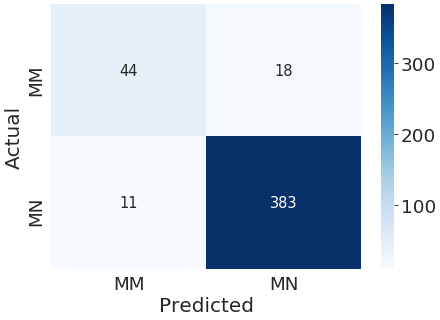

In [10]:
# data = np.array([[ 51.,  11.],
#                  [ 12., 380.]])

data = np.array([[ 44.,  18.],
                 [ 11., 383.]])

if False: 
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
# df_cm = pd.DataFrame(data, columns=['C43', 'D22'], index = ['C43', 'D22'])
df_cm = pd.DataFrame(data, columns=['MM', 'MN'], index = ['MM', 'MN'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='g')# font size

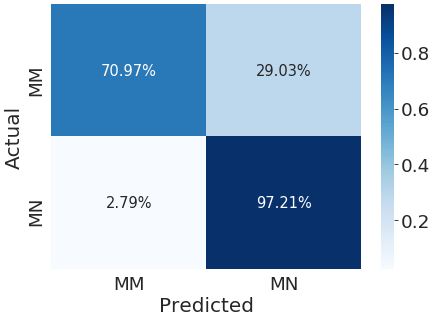

In [11]:
# data = np.array([[ 51.,  11.],
#                  [ 12., 380.]])

data = np.array([[ 44.,  18.],
                 [ 11., 383.]])

if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]

# df_cm = pd.DataFrame(data, columns=['C43', 'D22'], index = ['C43', 'D22'])
df_cm = pd.DataFrame(data, columns=['MM', 'MN'], index = ['MM', 'MN'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='.2%')# font size

# ClassSet8

In [12]:
layers = [1,2,3] #,4,5
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
        print('--------------------------------')    
        print('Melanoma-like lesions vs. all other:')
        classes_map_dict={0:0, 1:1, 2:1, 3:1, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL', 'PB+KL+NonMSC+Other'])
        
        print('--------------------------------')    
        print('Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+NonMSC', 'PB+KL+Other'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
TPR=[0.57449883 0.76547424 0.5399288  0.38092692 0.71887982], TNR=[0.98200603 0.85910288 0.94671814 0.96320945 0.75773524], PPV=[0.61739065 0.68957783 0.68925676 0.5868297  0.63175833], NPV=[0.97913278 0.90030999 0.90550843 0.91791935 0.82467504], FPR=[0.01799397 0.14089712 0.05328186 0.03679055 0.24226476], FNR=[0.42550117 0.23452576 0.4600712  0.61907308 0.28112018], FDR=[0.38260935 0.31042217 0.31074324 0.4131703  0.36824167], ACC=[0.96287138 0.83187314 0.87440723 0.89193616 0.74372269], F1_micro=0.6524052947217598, F1_macro=0.6085857258786647, F1_weighted=0.6442883823273526
[[ 38.  15.   1.   4.   8.]
 [ 12. 310.  17.   4.  62.]
 [  2.  37. 133.  12.  64.]
 [  7.   8.   9.  65.  82.]
 [  3.  81.  34.  25. 365.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.61      0.58      0.59        66
       Pigmented_benign       0.69      0.77      0.72       405
        Keratin_lesions       0.69      0.54      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.65535388 0.86734257 0.66613373 0.53190263 0.80699681], TNR=[0.9904095  0.89137529 0.97348914 0.97967955 0.81874835], PPV=[0.77739321 0.76566942 0.84423828 0.78902058 0.71796463], NPV=[0.98305715 0.94286637 0.93119335 0.93759671 0.88165542], FPR=[0.0095905  0.10862471 0.02651086 0.02032045 0.18125165], FNR=[0.34464612 0.13265743 0.33386627 0.46809737 0.19300319], FDR=[0.22260679 0.23433058 0.15576172 0.21097942 0.28203537], ACC=[0.9745786  0.88444766 0.9189874  0.92487831 0.81448145], F1_micro=0.7586867065169207, F1_macro=0.7314923448332717, F1_weighted=0.7544606178508879
[[ 173.   46.    5.    8.   32.]
 [  21. 1405.   37.    8.  149.]
 [   3.   95.  661.   32.  201.]
 [  15.   25.   17.  364.  263.]
 [  12.  265.   63.   52. 1640.]]
                         precision    recall  f1-score   support

  Melanoma_like_lesions       0.77      0.66      0.71       264
       Pigmented_benign       0.77      0.87      0.81      1620
        Keratin_lesions       0.84      0.67      0.7

TPR=[0.58398934 0.97999109], TNR=[0.97999109 0.58398934], PPV=[0.59863248 0.97919084], NPV=[0.97919084 0.59863248], FPR=[0.02000891 0.41601066], FNR=[0.41601066 0.02000891], FDR=[0.40136752 0.02080916], ACC=[0.96109296 0.96109296], F1_micro=0.9610929619424665, F1_macro=0.7833752517605023, F1_weighted=0.9608878372479224
[[  38.   28.]
 [  27. 1305.]]
                    precision    recall  f1-score   support

               MLL       0.58      0.58      0.58        66
PB+KL+NonMSC+Other       0.98      0.98      0.98      1332

          accuracy                           0.96      1398
         macro avg       0.78      0.78      0.78      1398
      weighted avg       0.96      0.96      0.96      1398

--------------------------------
Melanoma-like lesions+non-melanoma skin cancers vs. pigmented benign lesions + keratin lesions:
TPR=[0.54817148 0.95091882], TNR=[0.95091882 0.54817148], PPV=[0.69449034 0.91191684], NPV=[0.91191684 0.69449034], FPR=[0.04908118 0.45182852], FNR=[0.4518

### 2 - layers have best F1(TPR) for clas MLL

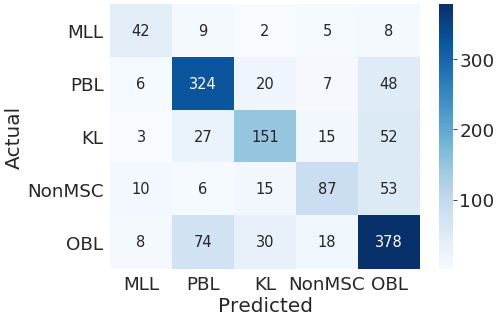

In [13]:
# data = np.array([[ 49.,   6.,   1.,   5.,   5.],
#                  [  4., 327.,  22.,   8.,  45.],
#                  [  0.,  27., 153.,  18.,  50.],
#                  [  6.,   3.,  14., 100.,  48.],
#                  [  4.,  62.,  33.,  33., 376.]])
data = np.array([[ 42.,   9.,   2.,   5.,   8.],
                 [  6., 324.,  20.,   7.,  48.],
                 [  3.,  27., 151.,  15.,  52.],
                 [ 10.,   6.,  15.,  87.,  53.],
                 [  8.,  74.,  30.,  18., 378.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='g')# font size .2%

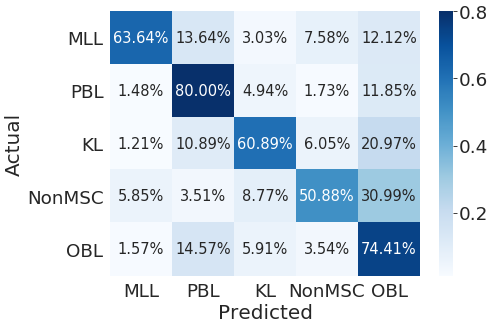

In [14]:
# data = np.array([[ 49.,   6.,   1.,   5.,   5.],
#                  [  4., 327.,  22.,   8.,  45.],
#                  [  0.,  27., 153.,  18.,  50.],
#                  [  6.,   3.,  14., 100.,  48.],
#                  [  4.,  62.,  33.,  33., 376.]])
data = np.array([[ 42.,   9.,   2.,   5.,   8.],
                 [  6., 324.,  20.,   7.,  48.],
                 [  3.,  27., 151.,  15.,  52.],
                 [ 10.,   6.,  15.,  87.,  53.],
                 [  8.,  74.,  30.,  18., 378.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'], index = ['MLL', 'PBL', 'KL', 'NonMSC', 'OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='.2%')# font size .2%

## ClassSet8 - NonMSC vs rest

In [15]:
layers = [1,2,3,4,5]
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
#         multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
    
        print('--------------------------------')    
        print('NonMSC vs MLL+PB+KL+Other:')
        classes_map_dict={0:0, 1:0, 2:0, 3:1, 4:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+PB+KL+Other', 'NonMSC'])
        
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
        
        print('--------------------------------')    
        print('NonMSC vs MLL+PB+KL+Other:')
        classes_map_dict={0:0, 1:0, 2:0, 3:1, 4:0}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+PB+KL+Other', 'NonMSC'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.96320945 0.38092692], TNR=[0.38092692 0.96320945], PPV=[0.91791935 0.5868297 ], NPV=[0.5868297  0.91791935], FPR=[0.61907308 0.03679055], FNR=[0.03679055 0.61907308], FDR=[0.08208065 0.4131703 ], ACC=[0.89193616 0.89193616], F1_micro=0.8919361600520773, F1_macro=0.698430883065979, F1_weighted=0.8808218307949236
[[1182.   45.]
 [ 106.   65.]]
                 precision    recall  f1-score   support

MLL+PB+KL+Other       0.92      0.96      0.94      1227
         NonMSC       0.59      0.38      0.46       171

       accuracy                           0.89      1398
      macro avg       0.75      0.67      0.70      1398
   weighted avg       0.88      0.89      0.88      1398

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.97967955 0.53190263], TNR=[0.53190263 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


TPR=[0.96322982 0.50858586], TNR=[0.50858586 0.96322982], PPV=[0.93355291 0.6576012 ], NPV=[0.6576012  0.93355291], FPR=[0.49141414 0.03677018], FNR=[0.03677018 0.49141414], FDR=[0.06644709 0.3423988 ], ACC=[0.90745284 0.90745284], F1_micro=0.9074528428204811, F1_macro=0.7595169565985713, F1_weighted=0.9018355127689798
[[1182.   45.]
 [  84.   87.]]
                 precision    recall  f1-score   support

MLL+PB+KL+Other       0.93      0.96      0.95      1227
         NonMSC       0.66      0.51      0.57       171

       accuracy                           0.91      1398
      macro avg       0.80      0.74      0.76      1398
   weighted avg       0.90      0.91      0.90      1398

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
NonMSC vs MLL+PB+KL+Other:
TPR=[0.98291556 0.78489698], TNR=[0.78489698 0.98291556], PPV=[0.97048022 0.86756464], NPV=[0.86756464 0.97048022], FPR=[0.21510302 0.

FileNotFoundError: [Errno 2] File /mnt/models/darts_retrained/4ch_128x128_12inchannel_no_metainfo_registered_5Fold_newC43_augC43_v1_21Dec2020/XV2_SGD_orig_02DropChannel_4lrs_15Dec_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-0/validation7ch_logits_predictions.csv does not exist: '/mnt/models/darts_retrained/4ch_128x128_12inchannel_no_metainfo_registered_5Fold_newC43_augC43_v1_21Dec2020/XV2_SGD_orig_02DropChannel_4lrs_15Dec_newC43NoDup_ClassSet8_ManCorected_registered_350epochs_fold-0/validation7ch_logits_predictions.csv'

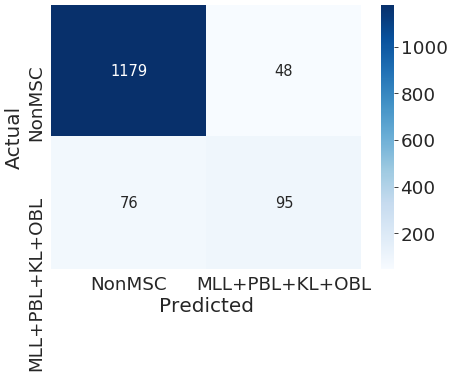

In [45]:
# data = np.array([[572.,  35.],
#                  [ 34.,  52.]])

# 2 -layers - best TPR
data = np.array([[1179.,   48.],
                 [  76.,   95.]])

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='g')# font size .2%

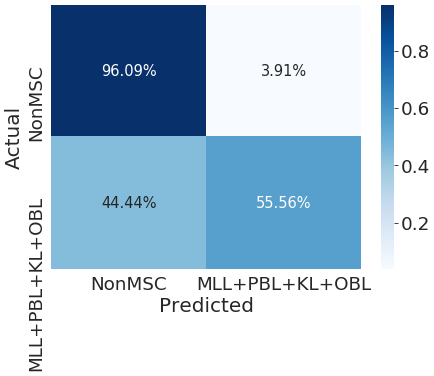

In [40]:
# data = np.array([[572.,  35.],
#                  [ 34.,  52.]])

# 2 -layers - best TPR
data = np.array([[1179.,   48.],
                 [  76.,   95.]])
if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=['NonMSC', 'MLL+PBL+KL+OBL'], index = ['NonMSC', 'MLL+PBL+KL+OBL'])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=50)
sn.set(font_scale=2.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 21}, fmt='.2%')# font size .2%

## ClassSet8 (MLL+nonMSC) vs. benign lesions (PBL+KL+OBL)

In [54]:
layers = [1,2,3,4,5]
sets = [8]

folds_n = 5
classes_n = 5

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
          
#         multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
    
        print('--------------------------------')    
        print('(MLL+nonMSC) vs. benign lesions (PBL+KL+OBL):')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+nonMSC', 'PBL+KL+OBL'])
        
        
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
#         classes_map_dict = None
#         multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
#         multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['Melanoma_like_lesions', 'Pigmented_benign', 'Keratin_lesions', 'Nonmelanoma_skin_cancer', 'Other'])
        
        print('--------------------------------')    
        print('(MLL+nonMSC) vs. benign lesions (PBL+KL+OBL):')
        classes_map_dict={0:0, 1:1, 2:1, 3:0, 4:1}
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n=2)
        multi_class_folds_metrics.print_scores()
        multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['MLL+nonMSC', 'PBL+KL+OBL'])
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-8
Validation:
--------------------------------
(MLL+nonMSC) vs. benign lesions (PBL+KL+OBL):
TPR=[0.56646424 0.95745958], TNR=[0.95745958 0.56646424], PPV=[0.73709478 0.91544271], NPV=[0.91544271 0.73709478], FPR=[0.04254042 0.43353576], FNR=[0.43353576 0.04254042], FDR=[0.26290522 0.08455729], ACC=[0.89112782 0.89112782], F1_micro=0.8911278163451529, F1_macro=0.7871197618033384, F1_weighted=0.8854564825603329
[[ 134.  103.]
 [  49. 1112.]]
              precision    recall  f1-score   support

  MLL+nonMSC       0.73      0.57      0.64       237
  PBL+KL+OBL       0.92      0.96      0.94      1161

    accuracy                           0.89      1398
   macro avg       0.82      0.76      0.79      1398
weighted avg       0.88      0.89      0.89      1398

--------------------------------
--------------------------------
--------------------------------
Training:
--------------------------------
(MLL+nonMSC) vs. benign lesions (PBL+KL+OBL):
TPR=[0.72016022 0.97829414

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:117: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:118: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


              precision    recall  f1-score   support

  MLL+nonMSC       0.87      0.72      0.79       948
  PBL+KL+OBL       0.94      0.98      0.96      4644

    accuracy                           0.93      5592
   macro avg       0.91      0.85      0.87      5592
weighted avg       0.93      0.93      0.93      5592

--------------------------------
--------------------------------
Layers-2, Set-8
Validation:
--------------------------------
(MLL+nonMSC) vs. benign lesions (PBL+KL+OBL):
TPR=[0.63484422 0.95631068], TNR=[0.95631068 0.63484422], PPV=[0.74971997 0.92783036], NPV=[0.92783036 0.74971997], FPR=[0.04368932 0.36515578], FNR=[0.36515578 0.04368932], FDR=[0.25028003 0.07216964], ACC=[0.90177976 0.90177976], F1_micro=0.9017797575655916, F1_macro=0.8136117778552313, F1_weighted=0.8983276326343154
[[ 150.   87.]
 [  51. 1110.]]
              precision    recall  f1-score   support

  MLL+nonMSC       0.75      0.63      0.68       237
  PBL+KL+OBL       0.93      0.96      

In [26]:
# val_file_template="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation4_logits_predictions.csv"
# train_file_template="/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_5Fold_newC43-5f/XV2_SGD_orig_02DropChannel_{}lrs_2oct_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train4_logits_predictions.csv"

val_file_template="/mnt/models/darts_retrained/4ch_128x128_12inchannel_no_metainfo_registered_5Fold_newC43_augC43_v1_21Dec2020_32classes/XV2_SGD_orig_02DropChannel_{}lrs_15Dec_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/validation7ch_logits_predictions.csv"
train_file_template=     "/mnt/models/darts_retrained/4ch_128x128_12inchannel_no_metainfo_registered_5Fold_newC43_augC43_v1_21Dec2020_32classes/XV2_SGD_orig_02DropChannel_{}lrs_15Dec_newC43NoDup_ClassSet{}_ManCorected_registered_350epochs_fold-{}/train7ch_logits_predictions.csv"



# ClassSet9

In [52]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)
# np.set_printoptions(threshold=np.inf)
numpy.set_printoptions(linewidth=250)


layers = [1,2,3,4,5]
sets = [9]

folds_n = 5
classes_n = 32

for l in layers:
    for set_id in sets:
        
        print('Layers-{}, Set-{}'.format(l, set_id))
        
        print('Validation:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/validation2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(val_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['c43','d03','d03.9','d22','l81.2','l81.4','q82.5','d86.3','l21','l57','l57.0','l82','l85','l85.1','l85.5','l85.8','q80','c44','c46','d09','a63','d18','d21.9','d48','l92','l94.2','l98.8','pxe','b07','ada','l57.9','l98.9'])
          
        print('--------------------------------')
        print('--------------------------------')
        print('--------------------------------')
        
        print('Training:')
#         val_file_template = "/mnt/models/darts_retrained/6ch_128x128_no_metainfo_registered_10Fold/XV2_SGD_orig_02DropChannel_{}lrs_2oct_ClassSet{}_ManCorected_registered_fold-{}/train2_logits_predictions.csv"
        multi_class_folds_metrics = build_multi_class_metrics_list(train_file_template, l, set_id, folds_n, classes_n)
        
        classes_map_dict = None
        multi_class_folds_metrics.calc_scores(classes_map_dict, classes_n)
        multi_class_folds_metrics.print_scores()
#         multi_class_folds_metrics.print_mean_classification_report(classes_map_dict, target_names=['c43','d03','d03.9','d22','l81.2','l81.4','q82.5','d86.3','l21','l57','l57.0','l82','l85','l85.1','l85.5','l85.8','q80','c44','c46','d09','a63','d18','d21.9','d48','l92','l94.2','l98.8','pxe','b07','ada','l57.9','l98.9'])
          
        print('--------------------------------')
        print('================================')
        print('--------------------------------')


Layers-1, Set-9
Validation:
TPR=[0.59582418 1.         0.6        0.83220034 0.9        0.43333333 0.9        0.5        0.7        0.46666667 0.7        0.47749288 0.10766082 0.9        0.8        0.9        0.46666667 0.58309142 1.         0.46666667 0.8        0.42119048
 0.6        0.11441558 0.46666667 0.6        0.46666667 0.93181818 0.17111111 0.90365079 0.19801587 0.16969697], TNR=[0.97857262 1.         1.         0.77991166 1.         1.         1.         1.         1.         0.99869452 0.99932203 0.95715623 0.98031964 1.         1.         1.         0.99805195 0.92588657 1.         1.         0.99931973 0.99401823
 0.99931973 0.98548642 1.         0.99936102 1.         0.97276139 0.99451419 0.9754327  0.98794073 0.99007964], PPV=[0.57464896 1.         1.         0.56818847 1.         1.         1.         1.         1.         0.8        0.9        0.52119264 0.2602381  1.         1.         1.         0.85       0.48268945 1.         1.         0.93333333 0.59285714
 0.9 

TPR=[0.72298082 1.         0.76       0.92914953 0.6        0.20952381 1.         0.4        0.48333333 0.48611111 0.66666667 0.64100733 0.22691652 0.8        0.53333333 0.6        0.50666667 0.69458296 1.         0.54       0.96666667 0.71703851
 0.72       0.16619649 0.24       0.64       0.62       0.99545455 0.20695187 0.97823971 0.56295567 0.3974026 ], TNR=[0.98909121 1.         0.99964996 0.79788731 1.         0.99982472 1.         1.         1.         1.         0.99982788 0.96956996 0.98851464 1.         0.99982533 1.         0.99913008 0.95119766 1.         1.         0.99913176 0.99749057
 0.9996526  0.98937174 1.         0.99982654 0.99982472 0.98095501 0.99750265 0.98619884 0.99251737 0.9940852 ], PPV=[0.75775399 1.         0.92       0.63867958 1.         0.9        1.         1.         1.         1.         0.96       0.67704528 0.57219135 1.         0.9        1.         0.82       0.65037934 1.         1.         0.85952381 0.88322354
 0.92666667 0.57218345 1.        

TPR=[0.64454212 1.         0.8        0.83733005 0.9        0.43333333 0.9        0.6        0.7        0.53333333 0.8        0.54358974 0.12988304 0.9        0.8        0.9        0.46666667 0.66526611 1.         0.73333333 0.9        0.72261905
 0.8        0.15164502 0.56666667 0.8        0.66666667 0.98333333 0.17333333 0.95492063 0.41746032 0.15151515], TNR=[0.98075068 1.         0.99939577 0.86229152 1.         0.99810356 0.99870096 1.         1.         0.99875291 1.         0.95914559 0.97766021 1.         1.         1.         0.99939394 0.93440529 1.         1.         0.99805142 0.99934641
 1.         0.98756086 0.99871167 0.99737168 0.99931973 0.97676438 0.99394912 0.96052769 0.97382894 0.99540044], PPV=[0.64374797 1.         0.9        0.68127295 1.         0.7        0.83333333 1.         1.         0.83333333 1.         0.56598898 0.31877289 1.         1.         1.         0.9        0.55151911 1.         1.         0.81666667 0.97142857
 1.         0.56666667 0.83333333

TPR=[0.94061483 1.         0.91       0.9550951  1.         0.41904762 1.         0.84       0.48333333 0.51666667 0.81666667 0.89630037 0.50159871 0.6        1.         0.6        0.37333333 0.82535545 1.         0.88666667 0.88666667 0.98020022
 0.96       0.45432425 0.83333333 0.8        0.78666667 1.         0.66221034 0.99855072 0.84059113 0.57800866], TNR=[0.99526507 1.         0.99912821 0.93660238 0.99982818 0.99965215 1.         0.99965308 1.         0.99947749 0.99965382 0.97320062 0.99073514 1.         0.99982803 1.         0.9996511  0.97388995 1.         1.         0.99930465 0.99928642
 1.         0.99252551 0.99842121 0.9996477  0.99930417 0.98408217 0.994615   0.99228054 0.99052477 0.99677631], PPV=[0.90240327 1.         0.81333333 0.85220529 0.93333333 0.86666667 1.         0.93333333 1.         0.89285714 0.9        0.77063626 0.78247797 1.         0.95       1.         0.86       0.80850204 1.         1.         0.9047619  0.97374861
 1.         0.8215783  0.77111111

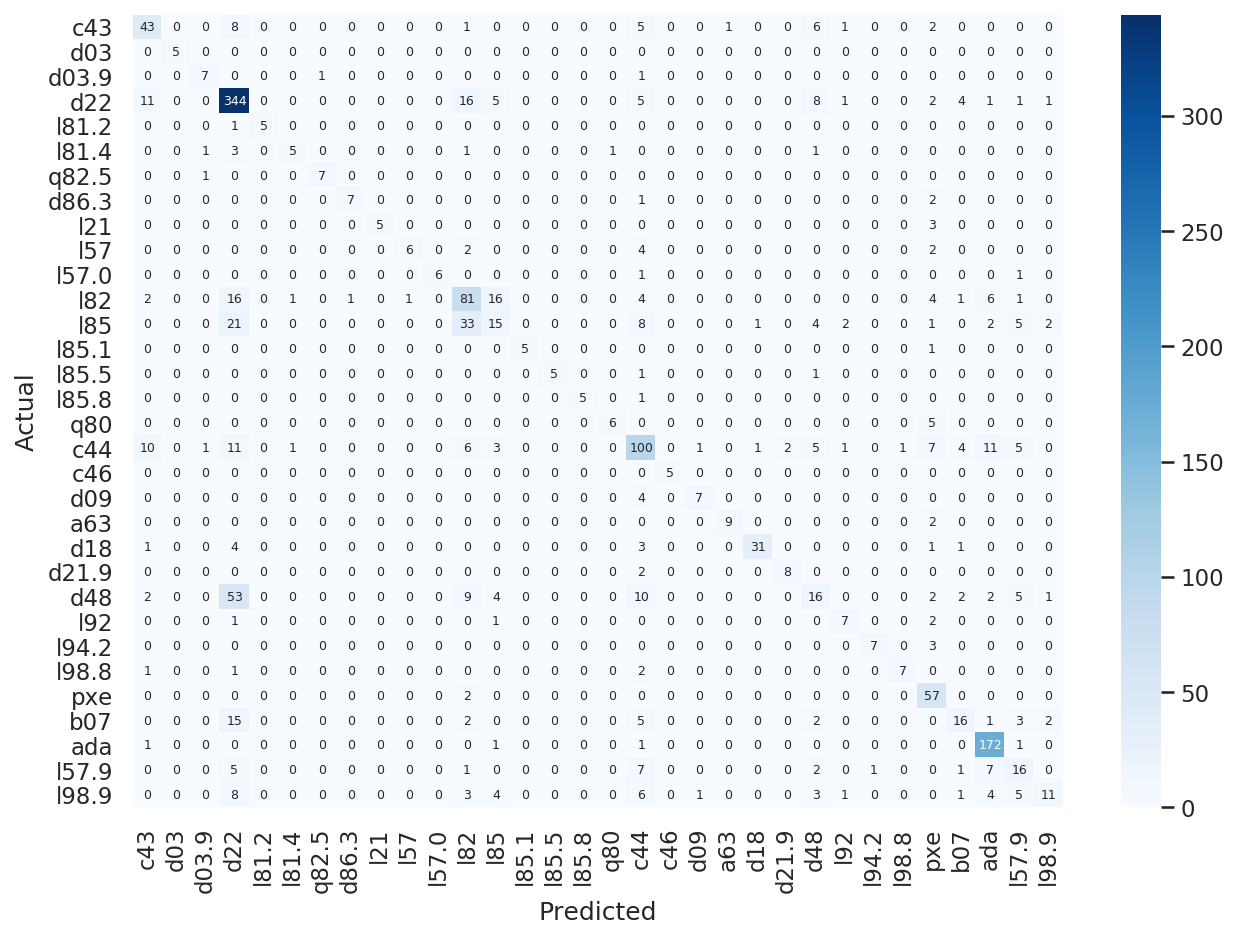

In [57]:
# data = np.array([[ 49.,   6.,   1.,   5.,   5.],
#                  [  4., 327.,  22.,   8.,  45.],
#                  [  0.,  27., 153.,  18.,  50.],
#                  [  6.,   3.,  14., 100.,  48.],
#                  [  4.,  62.,  33.,  33., 376.]])
data = np.array([[ 43.,   0.,   0.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   1.,   0.,   0.,   6.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,   0.], 
                 [  0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   7.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [ 11.,   0.,   0., 344.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  16.,   5.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   8.,   1.,   0.,   0.,   2.,   4.,   1.,   1.,   1.], 
                 [  0.,   0.,   0.,   1.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   1.,   3.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   1.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.], 
                 [  2.,   0.,   0.,  16.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,  81.,  16.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   1.,   6.,   1.,   0.], 
                 [  0.,   0.,   0.,  21.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  33.,  15.,   0.,   0.,   0.,   0.,   8.,   0.,   0.,   0.,   1.,   0.,   4.,   2.,   0.,   0.,   1.,   0.,   2.,   5.,   2.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.], 
                 [ 10.,   0.,   1.,  11.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   6.,   3.,   0.,   0.,   0.,   0., 100.,   0.,   1.,   0.,   1.,   2.,   5.,   1.,   0.,   1.,   7.,   4.,  11.,   5.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.], 
                 [  1.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,  31.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  2.,   0.,   0.,  53.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   9.,   4.,   0.,   0.,   0.,   0.,  10.,   0.,   0.,   0.,   0.,   0.,  16.,   0.,   0.,   0.,   2.,   2.,   2.,   5.,   1.], 
                 [  0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   2.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   3.,   0.,   0.,   0.,   0.], 
                 [  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  57.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,  15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,  16.,   1.,   3.,   2.], 
                 [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 172.,   1.,   0.], 
                 [  0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,   0.,   1.,   7.,  16.,   0.], 
                 [  0.,   0.,   0.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   4.,   0.,   0.,   0.,   0.,   6.,   0.,   1.,   0.,   0.,   0.,   3.,   1.,   0.,   0.,   0.,   1.,   4.,   5.,  11.]] )

col_names = ['c43','d03','d03.9','d22','l81.2','l81.4','q82.5','d86.3','l21','l57','l57.0','l82','l85','l85.1','l85.5','l85.8','q80','c44','c46','d09','a63','d18','d21.9','d48','l92','l94.2','l98.8','pxe','b07','ada','l57.9','l98.9']

if False:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=col_names, index = col_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7), dpi=150)
sn.set(font_scale=1.0)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 6}, fmt='g')# font size .2%

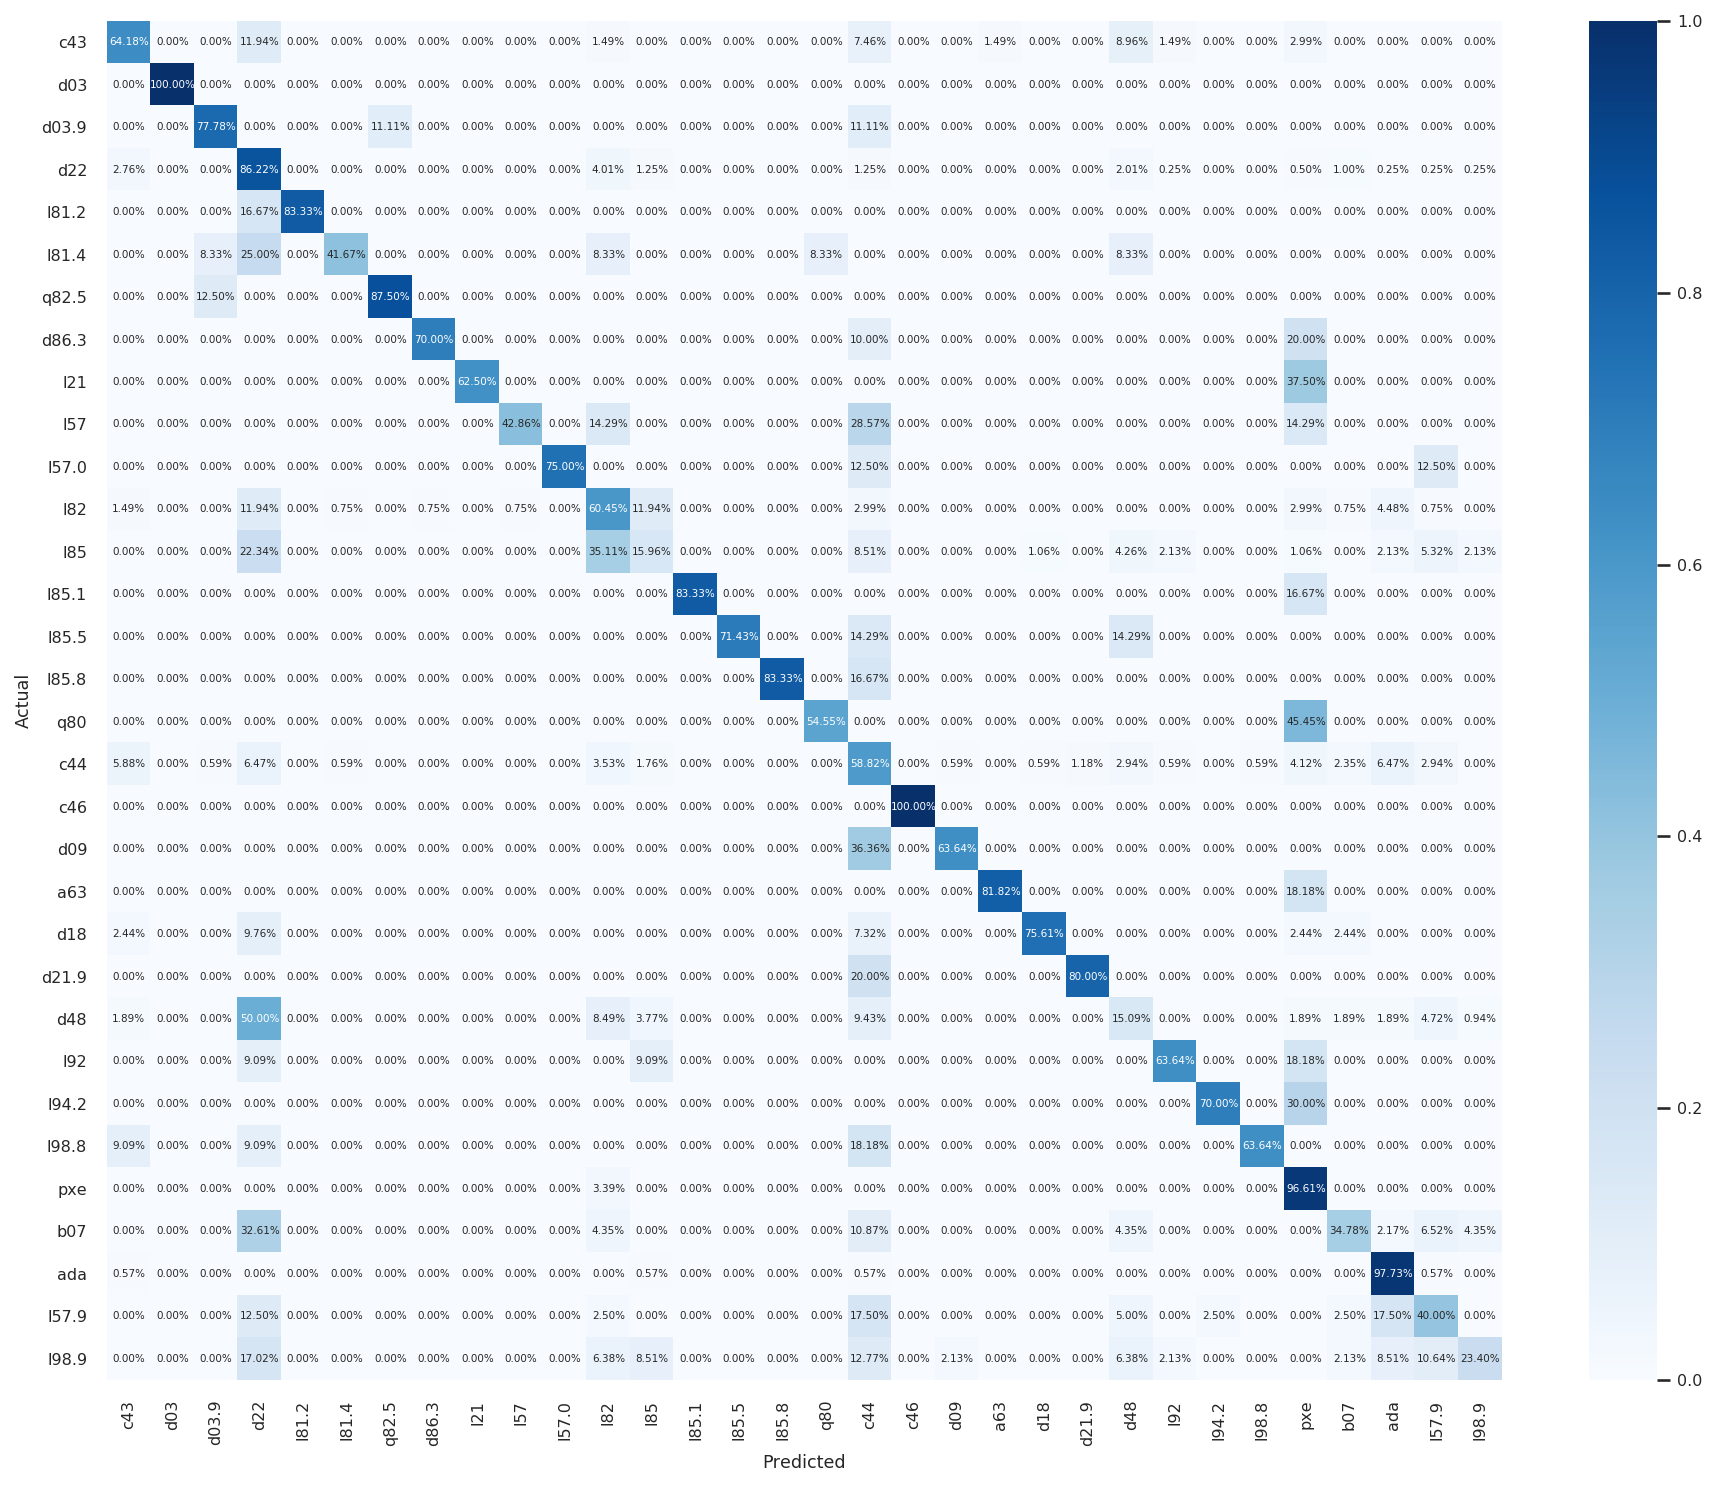

In [63]:
# data = np.array([[ 49.,   6.,   1.,   5.,   5.],
#                  [  4., 327.,  22.,   8.,  45.],
#                  [  0.,  27., 153.,  18.,  50.],
#                  [  6.,   3.,  14., 100.,  48.],
#                  [  4.,  62.,  33.,  33., 376.]])
data = np.array([[ 43.,   0.,   0.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   1.,   0.,   0.,   6.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,   0.], 
                 [  0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   7.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [ 11.,   0.,   0., 344.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  16.,   5.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   8.,   1.,   0.,   0.,   2.,   4.,   1.,   1.,   1.], 
                 [  0.,   0.,   0.,   1.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   1.,   3.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   1.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.], 
                 [  2.,   0.,   0.,  16.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,  81.,  16.,   0.,   0.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   1.,   6.,   1.,   0.], 
                 [  0.,   0.,   0.,  21.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  33.,  15.,   0.,   0.,   0.,   0.,   8.,   0.,   0.,   0.,   1.,   0.,   4.,   2.,   0.,   0.,   1.,   0.,   2.,   5.,   2.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   6.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.], 
                 [ 10.,   0.,   1.,  11.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   6.,   3.,   0.,   0.,   0.,   0., 100.,   0.,   1.,   0.,   1.,   2.,   5.,   1.,   0.,   1.,   7.,   4.,  11.,   5.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   4.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   9.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.], 
                 [  1.,   0.,   0.,   4.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   0.,   0.,   0.,  31.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.], 
                 [  2.,   0.,   0.,  53.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   9.,   4.,   0.,   0.,   0.,   0.,  10.,   0.,   0.,   0.,   0.,   0.,  16.,   0.,   0.,   0.,   2.,   2.,   2.,   5.,   1.], 
                 [  0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   2.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   3.,   0.,   0.,   0.,   0.], 
                 [  1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  57.,   0.,   0.,   0.,   0.], 
                 [  0.,   0.,   0.,  15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,  16.,   1.,   3.,   2.], 
                 [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 172.,   1.,   0.], 
                 [  0.,   0.,   0.,   5.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   7.,   0.,   0.,   0.,   0.,   0.,   2.,   0.,   1.,   0.,   0.,   1.,   7.,  16.,   0.], 
                 [  0.,   0.,   0.,   8.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   4.,   0.,   0.,   0.,   0.,   6.,   0.,   1.,   0.,   0.,   0.,   3.,   1.,   0.,   0.,   0.,   1.,   4.,   5.,  11.]] )

col_names = ['c43','d03','d03.9','d22','l81.2','l81.4','q82.5','d86.3','l21','l57','l57.0','l82','l85','l85.1','l85.5','l85.8','q80','c44','c46','d09','a63','d18','d21.9','d48','l92','l94.2','l98.8','pxe','b07','ada','l57.9','l98.9']

if True:
    data = data.astype('float') / data.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(data, columns=col_names, index = col_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (15,12), dpi=150)
sn.set(font_scale=0.7)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 5}, fmt='.2%')# font size .2%